# Tables and Figures
Author: Mark Bauer

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
import matplotlib.ticker as ticker
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cpi
cpi.update()
from datetime import date

plt.rcParams['savefig.facecolor'] = 'white'

In [2]:
# sanity check data
%ls data/

FimaNfipClaims.parquet


In [3]:
# create a DuckDB database instance
con = duckdb.connect()

# create table claims of dataset
con.execute("""
    CREATE TABLE claims AS
        FROM read_parquet('data/FimaNfipClaims.parquet')
""")

# sanity check
con.sql("""
    SELECT *
    FROM claims
    LIMIT 5
""").show()

┌──────────────────────┬──────────────────────┬───┬──────────────┬──────────────┬──────────────────────┐
│ agricultureStructu…  │       asOfDate       │ … │   latitude   │  longitude   │          id          │
│       boolean        │ timestamp with tim…  │   │ decimal(9,1) │ decimal(9,1) │         uuid         │
├──────────────────────┼──────────────────────┼───┼──────────────┼──────────────┼──────────────────────┤
│ false                │ 2020-12-11 11:25:4…  │ … │         30.3 │        -87.7 │ ac2b2b72-4b71-4415…  │
│ false                │ 2020-11-13 09:50:3…  │ … │         30.3 │        -87.7 │ dd95560b-afd1-46cb…  │
│ false                │ 2022-04-21 15:56:4…  │ … │         32.5 │        -86.4 │ e434f7e3-eeff-42e4…  │
│ false                │ 2020-03-09 15:28:2…  │ … │         32.5 │        -86.4 │ 5ddd1b02-a847-4b20…  │
│ false                │ 2020-01-22 11:55:5…  │ … │         32.5 │        -86.5 │ a6a39c3c-8ee5-47e9…  │
├──────────────────────┴──────────────────────┴───┴────

In [4]:
# list tables and schemas
con.sql("SHOW ALL TABLES").df()

,database,schema,name,column_names,column_types,temporary
0,memory,main,claims,"[agricultureStructureIndicator, asOfDate, base...","[BOOLEAN, TIMESTAMP WITH TIME ZONE, SMALLINT, ...",False


In [5]:
# count of rows
con.sql("""
    SELECT COUNT(*) AS count_rows
    FROM claims
""").show()

┌────────────┐
│ count_rows │
│   int64    │
├────────────┤
│    2709121 │
└────────────┘



In [6]:
# count of columns
con.sql("""
    SELECT COUNT(column_name) AS count_columns
    FROM (DESCRIBE FROM claims)
""").show()

┌───────────────┐
│ count_columns │
│     int64     │
├───────────────┤
│            73 │
└───────────────┘



In [7]:
# last refreshed
con.sql("""
    SELECT asOfDate
    FROM claims
    ORDER BY asOfDate DESC
    LIMIT 1
""").show()

┌───────────────────────────────┐
│           asOfDate            │
│   timestamp with time zone    │
├───────────────────────────────┤
│ 2025-04-04 18:15:24.042001-04 │
└───────────────────────────────┘



# Examine Dataset

## Column Info

In [8]:
# examine column datatypes
con.sql("""
    SELECT
        column_name,
        column_type
    FROM (DESCRIBE claims)
""").show(max_rows=80)

┌────────────────────────────────────────────┬──────────────────────────┐
│                column_name                 │       column_type        │
│                  varchar                   │         varchar          │
├────────────────────────────────────────────┼──────────────────────────┤
│ agricultureStructureIndicator              │ BOOLEAN                  │
│ asOfDate                                   │ TIMESTAMP WITH TIME ZONE │
│ basementEnclosureCrawlspaceType            │ SMALLINT                 │
│ policyCount                                │ SMALLINT                 │
│ crsClassificationCode                      │ SMALLINT                 │
│ dateOfLoss                                 │ DATE                     │
│ elevatedBuildingIndicator                  │ BOOLEAN                  │
│ elevationCertificateIndicator              │ VARCHAR                  │
│ elevationDifference                        │ DECIMAL(6,1)             │
│ baseFloodElevation                  

In [9]:
# approximate column null percentage
con.sql("""
    SELECT
        column_name,
        null_percentage
    FROM
        (SUMMARIZE FROM claims)
    WHERE
        null_percentage > 0
    ORDER BY
        null_percentage DESC
""").show(max_rows=80)

┌────────────────────────────────────────────┬─────────────────┐
│                column_name                 │ null_percentage │
│                  varchar                   │  decimal(9,2)   │
├────────────────────────────────────────────┼─────────────────┤
│ floodCharacteristicsIndicator              │           98.53 │
│ eventDesignationNumber                     │           93.23 │
│ lowestAdjacentGrade                        │           81.10 │
│ crsClassificationCode                      │           79.69 │
│ nonPaymentReasonBuilding                   │           77.93 │
│ elevationCertificateIndicator              │           77.92 │
│ lowestFloorElevation                       │           76.36 │
│ baseFloodElevation                         │           75.67 │
│ elevationDifference                        │           72.95 │
│ floodZoneCurrent                           │           71.72 │
│ nfipCommunityNumberCurrent                 │           71.68 │
│ basementEnclosureCrawls

## Preview Data

In [10]:
# preview data
con.sql("""
    SELECT *
    FROM claims
    LIMIT 5
""").show()

┌──────────────────────┬──────────────────────┬───┬──────────────┬──────────────┬──────────────────────┐
│ agricultureStructu…  │       asOfDate       │ … │   latitude   │  longitude   │          id          │
│       boolean        │ timestamp with tim…  │   │ decimal(9,1) │ decimal(9,1) │         uuid         │
├──────────────────────┼──────────────────────┼───┼──────────────┼──────────────┼──────────────────────┤
│ false                │ 2020-12-11 11:25:4…  │ … │         30.3 │        -87.7 │ ac2b2b72-4b71-4415…  │
│ false                │ 2020-11-13 09:50:3…  │ … │         30.3 │        -87.7 │ dd95560b-afd1-46cb…  │
│ false                │ 2022-04-21 15:56:4…  │ … │         32.5 │        -86.4 │ e434f7e3-eeff-42e4…  │
│ false                │ 2020-03-09 15:28:2…  │ … │         32.5 │        -86.4 │ 5ddd1b02-a847-4b20…  │
│ false                │ 2020-01-22 11:55:5…  │ … │         32.5 │        -86.5 │ a6a39c3c-8ee5-47e9…  │
├──────────────────────┴──────────────────────┴───┴────

In [11]:
# preview data as pandas dataframe for readability
sql = """
    SELECT *
    FROM claims
    LIMIT 5
"""

# examine each column in sections because of large number of columns
con.sql(sql).df().iloc[:, :15]

,agricultureStructureIndicator,asOfDate,basementEnclosureCrawlspaceType,policyCount,crsClassificationCode,dateOfLoss,elevatedBuildingIndicator,elevationCertificateIndicator,elevationDifference,baseFloodElevation,ratedFloodZone,houseWorship,locationOfContents,lowestAdjacentGrade,lowestFloorElevation
0,False,2020-12-11 11:25:40.587000-05:00,0.0,1,NaN,2020-09-16,True,None,4.0,10.0,AE,False,7.0,4.4,14.4
1,False,2020-11-13 09:50:38.288000-05:00,2.0,1,NaN,2020-09-16,False,None,6.0,10.0,AE,False,NaN,0.0,16.0
2,False,2022-04-21 15:56:43.051000-04:00,NaN,1,8.0,2020-03-05,True,None,NaN,NaN,X,False,7.0,NaN,NaN
3,False,2020-03-09 15:28:27.372000-04:00,NaN,1,8.0,2017-06-22,True,None,NaN,NaN,X,False,7.0,NaN,NaN
4,False,2020-01-22 11:55:53.194965-05:00,NaN,1,8.0,2016-01-22,False,None,NaN,NaN,X,False,NaN,NaN,NaN


In [12]:
# slice through columns
con.sql(sql).df().iloc[:, 15:30]

,numberOfFloorsInTheInsuredBuilding,nonProfitIndicator,obstructionType,occupancyType,originalConstructionDate,originalNBDate,amountPaidOnBuildingClaim,amountPaidOnContentsClaim,amountPaidOnIncreasedCostOfComplianceClaim,postFIRMConstructionIndicator,rateMethod,smallBusinessIndicatorBuilding,totalBuildingInsuranceCoverage,totalContentsInsuranceCoverage,yearOfLoss
0,3,False,54.0,1,1991-09-17,2017-10-05,2750.18,121.0,0.0,True,8,False,10800,700,2020
1,2,False,NaN,2,1975-01-01,2008-10-20,2695.44,0.0,0.0,True,8,False,7400,0,2020
2,2,False,NaN,1,1968-01-03,2017-02-02,NaN,NaN,NaN,False,7,False,30000,12000,2020
3,2,False,NaN,1,1968-01-03,2017-02-02,13203.99,0.0,0.0,False,7,False,30000,12000,2017
4,1,False,NaN,1,1970-01-01,2015-10-20,NaN,NaN,NaN,False,R,False,250000,100000,2016


In [13]:
# slice through columns
con.sql(sql).df().iloc[:, 30:45]

,primaryResidenceIndicator,buildingDamageAmount,buildingDeductibleCode,netBuildingPaymentAmount,buildingPropertyValue,causeOfDamage,condominiumCoverageTypeCode,contentsDamageAmount,contentsDeductibleCode,netContentsPaymentAmount,contentsPropertyValue,disasterAssistanceCoverageRequired,eventDesignationNumber,ficoNumber,floodCharacteristicsIndicator
0,True,4000.0,F,2750.18,278027.0,1,N,1371.0,F,121.0,50000.0,0,AL0520,NaN,NaN
1,False,3945.0,F,2695.44,167531.0,1,N,0.0,None,0.0,0.0,0,AL0520,NaN,NaN
2,True,948.0,1,0.00,92418.0,4,N,NaN,1,0.0,NaN,0,None,NaN,NaN
3,True,14204.0,1,13203.99,164992.0,2,N,NaN,1,0.0,NaN,0,None,NaN,NaN
4,True,NaN,F,0.00,NaN,0,N,NaN,F,0.0,NaN,0,None,NaN,NaN


In [14]:
# slice through columns
con.sql(sql).df().iloc[:, 45:60]

,floodWaterDuration,floodproofedIndicator,floodEvent,iccCoverage,netIccPaymentAmount,nfipRatedCommunityNumber,nfipCommunityNumberCurrent,nfipCommunityName,nonPaymentReasonContents,nonPaymentReasonBuilding,numberOfUnits,buildingReplacementCost,contentsReplacementCost,replacementCostBasis,stateOwnedIndicator
0,NaN,False,Hurricane Sally,30000,0.0,015005,0000,None,None,None,0,314835.0,75000.0,A,False
1,NaN,False,Hurricane Sally,30000,0.0,015005,0000,None,None,None,0,185457.0,0.0,A,False
2,NaN,False,None,30000,0.0,010002,010002,"PRATTVILLE, CITY OF",06,01,1,293079.0,NaN,A,False
3,0.0,False,None,30000,0.0,010002,010002,"PRATTVILLE, CITY OF",97,None,1,214275.0,NaN,A,False
4,0.0,False,None,30000,0.0,010002,010002,"PRATTVILLE, CITY OF",06,06,1,NaN,NaN,A,False


In [15]:
# slice through columns
con.sql(sql).df().iloc[:, 60:]

,waterDepth,floodZoneCurrent,buildingDescriptionCode,rentalPropertyIndicator,state,reportedCity,reportedZipCode,countyCode,censusTract,censusBlockGroupFips,latitude,longitude,id
0,0.0,AE,1,False,AL,Currently Unavailable,36542,01003,01003011407,010030114072,30.3,-87.7,ac2b2b72-4b71-4415-966f-162f6f4feb6c
1,0.0,None,1,False,AL,Currently Unavailable,36542,01003,01003011407,010030114073,30.3,-87.7,dd95560b-afd1-46cb-b76a-19c58f2d9627
2,99.0,X,1,False,AL,Currently Unavailable,36066,01001,01001020400,010010204001,32.5,-86.4,e434f7e3-eeff-42e4-abc6-a5d49a1c84be
3,NaN,X,1,False,AL,Currently Unavailable,36066,01001,01001020400,010010204001,32.5,-86.4,5ddd1b02-a847-4b20-87be-5802da962064
4,0.0,AE,1,False,AL,Currently Unavailable,36067,01001,01001020600,010010206001,32.5,-86.5,a6a39c3c-8ee5-47e9-975f-6ad066a3adb7


In [16]:
# earliest and latest record effective date
con.sql("""
    SELECT
        min(asOfDate) AS earliestAsOfDate,
        max(asOfDate) AS latestAsOfDate
    FROM claims
""").show()

┌────────────────────────────┬───────────────────────────────┐
│      earliestAsOfDate      │        latestAsOfDate         │
│  timestamp with time zone  │   timestamp with time zone    │
├────────────────────────────┼───────────────────────────────┤
│ 2019-09-19 02:12:43.388-04 │ 2025-04-04 18:15:24.042001-04 │
└────────────────────────────┴───────────────────────────────┘



In [17]:
# earliest and latest date of loss in dataset
con.sql("""
    SELECT
        min(dateOfLoss) AS earliestDateOfLoss,
        max(dateOfLoss) AS latestDateOfLoss
    FROM claims
""").show()

┌────────────────────┬──────────────────┐
│ earliestDateOfLoss │ latestDateOfLoss │
│        date        │       date       │
├────────────────────┼──────────────────┤
│ 1978-01-01         │ 2025-04-04       │
└────────────────────┴──────────────────┘



In [18]:
# summary stats
con.sql("""
    SELECT
        COUNT(id) AS countClaims,
        ROUND(
            SUM(amountPaidOnBuildingClaim)
            + SUM(amountPaidOnContentsClaim)
            + SUM(amountPaidOnIncreasedCostOfComplianceClaim), 0)::BIGINT AS paidTotalClaim, 
        ROUND(SUM(amountPaidOnBuildingClaim), 0)::BIGINT AS paidBuildingClaim,
        ROUND(SUM(amountPaidOnContentsClaim), 0)::BIGINT AS paidContentsClaim, 
        ROUND(SUM(amountPaidOnIncreasedCostOfComplianceClaim), 0)::BIGINT AS paidICC
    FROM
        claims    
""").show()

┌─────────────┬────────────────┬───────────────────┬───────────────────┬───────────┐
│ countClaims │ paidTotalClaim │ paidBuildingClaim │ paidContentsClaim │  paidICC  │
│    int64    │     int64      │       int64       │       int64       │   int64   │
├─────────────┼────────────────┼───────────────────┼───────────────────┼───────────┤
│     2709121 │    87775002888 │       71337632479 │       15486136606 │ 951233804 │
└─────────────┴────────────────┴───────────────────┴───────────────────┴───────────┘



In [19]:
# summary statistics formatted for Markdown for README
summary_df = con.sql("""
    SELECT
        ROUND(COUNT(id) / 1_000_000.0, 2) AS countClaimM,
        
        ROUND((
            SUM(amountPaidOnBuildingClaim)
            + SUM(amountPaidOnContentsClaim)
            + SUM(amountPaidOnIncreasedCostOfComplianceClaim)
        ) / 1_000_000.0, 2) AS paidTotalClaimM,
        
        ROUND(SUM(amountPaidOnBuildingClaim) / 1_000_000.0, 2) AS paidBuildingM,
        ROUND(SUM(amountPaidOnContentsClaim) / 1_000_000.0, 2) AS paidContentsM,
        ROUND(SUM(amountPaidOnIncreasedCostOfComplianceClaim) / 1_000_000.0, 2) AS paidICCM
    FROM
        claims
""").df()

# print as Markdown for easy README insertion
print(summary_df.to_markdown(index=False))

|   countClaimM |   paidTotalClaimM |   paidBuildingM |   paidContentsM |   paidICCM |
|--------------:|------------------:|----------------:|----------------:|-----------:|
|          2.71 |             87775 |         71337.6 |         15486.1 |     951.23 |


In [20]:
year_loss_df = con.sql("""
    SELECT
        yearOfLoss,
        COUNT(id) AS countClaims,
        ROUND(
            SUM(amountPaidOnBuildingClaim)
            + SUM(amountPaidOnContentsClaim)
            + SUM(amountPaidOnIncreasedCostOfComplianceClaim), 0)::BIGINT AS paidTotalClaim
    FROM
        claims 
    WHERE
        yearOfLoss < 2025
    GROUP BY
        yearOfLoss 
   ORDER BY
       yearOfLoss
""").df()

# adjust for inflation in 2024 dollars
year_loss_df["paidTotalClaim2024"] = year_loss_df.apply(
    lambda x: cpi.inflate(
        x.paidTotalClaim,
        x.yearOfLoss,
        to=2024),
    axis=1
)

# transform to millions
year_loss_df = year_loss_df.assign(
    paidTotalClaimM = year_loss_df['paidTotalClaim'] / 1_000_000,
    paidTotalClaim2024M = year_loss_df['paidTotalClaim2024'] / 1_000_000
)

# preview
year_loss_df.head(10)

print(year_loss_df.shape)
year_loss_df.head()

(47, 6)


,yearOfLoss,countClaims,paidTotalClaim,paidTotalClaim2024,paidTotalClaimM,paidTotalClaim2024M
0,1978,35897,147719253,7.107041e+08,147.719253,710.704061
1,1979,87375,483281219,2.088154e+09,483.281219,2088.154302
2,1980,53227,230414295,8.771654e+08,230.414295,877.165410
3,1981,31174,127118031,4.386747e+08,127.118031,438.674676
4,1982,43106,198295820,6.445929e+08,198.295820,644.592927


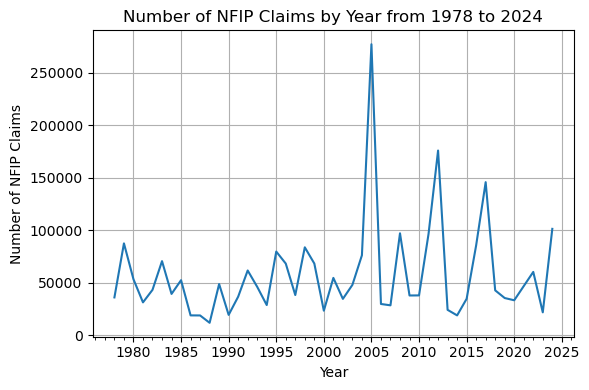

In [21]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.lineplot(
    data=year_loss_df,
    x='yearOfLoss',
    y='countClaims',
    ax=ax
)

plt.title("Number of NFIP Claims by Year from 1978 to 2024")
plt.xlabel("Year")
plt.ylabel("Number of NFIP Claims")

ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.grid(True)

plt.tight_layout()
plt.savefig('figures/year-count.png', dpi=200, bbox_inches='tight')

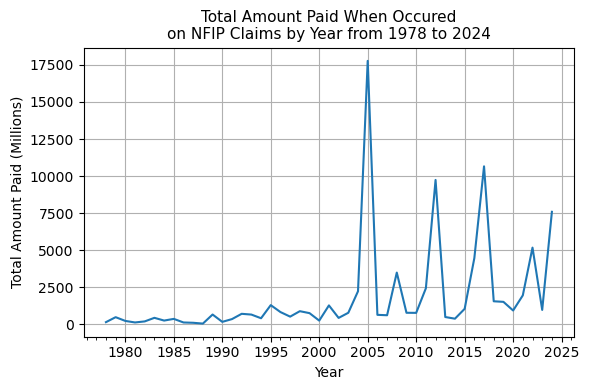

In [22]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.lineplot(
    data=year_loss_df,
    x='yearOfLoss',
    y='paidTotalClaimM',
    ax=ax
)

plt.title("Total Amount Paid When Occured\non NFIP Claims by Year from 1978 to 2024", fontsize=11)
plt.xlabel("Year")
plt.ylabel("Total Amount Paid (Millions)")

ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.grid(True)

plt.tight_layout()

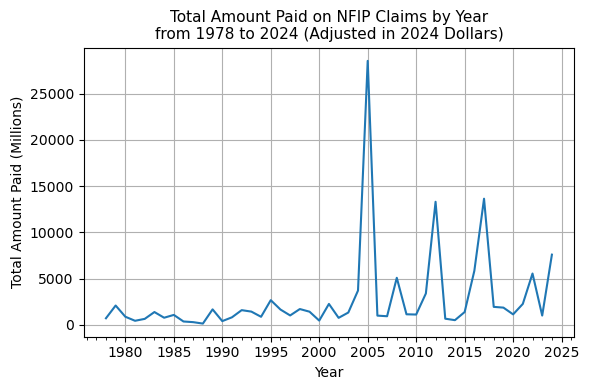

In [23]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.lineplot(
    data=year_loss_df,
    x='yearOfLoss',
    y='paidTotalClaim2024M',
    ax=ax
)

plt.title("Total Amount Paid on NFIP Claims by Year\nfrom 1978 to 2024 (Adjusted in 2024 Dollars)", fontsize=11)
plt.xlabel("Year")
plt.ylabel("Total Amount Paid (Millions)")

ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.grid(True)

plt.tight_layout()
plt.savefig('figures/year-amount-paid.png', dpi=200, bbox_inches='tight')

# Top 10 Most Significant Flood Events By Total Amount Paid

In [24]:
event_df = con.sql("""
    SELECT
        yearOfLoss,
        floodEvent,
        COUNT(id) AS countClaims,
        ROUND(
            SUM(amountPaidOnBuildingClaim)
            + SUM(amountPaidOnContentsClaim)
            + SUM(amountPaidOnIncreasedCostOfComplianceClaim), 0)::BIGINT AS paidTotalClaim
    FROM
        claims 
    WHERE
        floodEvent NOT NULL
    GROUP BY
        yearOfLoss,
        floodEvent    
""").df()

print(event_df.shape)
event_df.head()

(239, 4)


,yearOfLoss,floodEvent,countClaims,paidTotalClaim
0,2022,Hurricane Ian,48755,4830393644
1,2004,Hurricane Charley,6068,50914481
2,2022,Tropical Storm Alex,262,8315993
3,2024,Hurricane Milton,21409,1000257060
4,2023,Hurricane Idalia,5517,384115723


In [ ]:
event_df['yearOfLossFormatted'] = pd.to_datetime(event_df['yearOfLoss'].astype(str) + "-01-01")

# adjust in 2025 dollars
timestamp = pd.Timestamp(date(2025, 1, 1))

event_df["paidTotalClaim2025"] = event_df.apply(
    lambda x: cpi.inflate(
        x.paidTotalClaim,
        x.yearOfLossFormatted,
        to=timestamp),
    axis=1
)

event_df.head(10)

In [ ]:
# transform raw dollars to millions and calculate average paid claim
event_df = (
    event_df
    .assign(
        paidTotalClaimM = event_df['paidTotalClaim'] / 1_000_000,
        paidTotalClaimM2025 = event_df['paidTotalClaim2025'] / 1_000_000,
        averagePaidClaim2025 = event_df['paidTotalClaim2025'] / event_df['countClaims']
    )
    .astype({'paidTotalClaimM':int, 'paidTotalClaimM2025':int, 'averagePaidClaim2025':int})
    
    # sort by top 10 events on paid claims in 2025 dollars    
    .sort_values(by='paidTotalClaim2025', ascending=False)
    .head(10)
    .reset_index(drop=True) 
)

# add rank of events
event_df['rank'] = range(1, 11)

# rearrange columns
cols = [
    'rank', 'yearOfLoss', 'floodEvent',
    'countClaims', 'paidTotalClaimM',
    'paidTotalClaimM2025', 'averagePaidClaim2025'
]
 
event_df = event_df.loc[:, cols]

# preview
event_df

In [ ]:
# convert to Markdown for README display
print(event_df.to_markdown(index=False))

# Map

In [ ]:
# count claims by state
state_loss_df = con.sql("""
    SELECT
        state,
        COUNT(id) AS countClaim
    FROM
        claims  
    GROUP BY
        state
    ORDER BY
        state ASC  
""").df()

print(state_loss_df.shape)
state_loss_df.head()

In [ ]:
# read states shapefile
path = 'https://www2.census.gov/geo/tiger/TIGER2023/STATE/tl_2023_us_state.zip'
states_gdf = gpd.read_file(path)

# sanity check
print(states_gdf.shape)
states_gdf.head()

In [ ]:
# identify CRS
states_gdf.crs

In [ ]:
# merge nfip claims to state boundaries
states_merged = states_gdf.merge(
    state_loss_df,
    left_on='STUSPS',
    right_on='state',
    how='left'
)

# sanity check
states_merged.head()

In [ ]:
# examine NULLS count
states_merged.loc[states_merged['state'].isnull()]

In [ ]:
# calculate clount claims per kilometer and convert land area (sq meters) to sq kilometers
states_merged['countClaimkm'] = states_merged['countClaim'] / (states_merged['ALAND'] / 1_000_000)

states_merged.head()

In [ ]:
# locate conus only gdf
conus_gdf = states_merged.loc[
    (states_merged['GEOID'].astype(int) <= 56)
    & (~states_merged['GEOID'].isin(['02', '15']))
]

# transform CRS for display
conus_gdf = conus_gdf.to_crs(5070)

conus_gdf.head()

In [ ]:
# identify bounds of map for value scale
conus_gdf['countClaim'].describe()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmap = plt.cm.Blues
norm = mpl.colors.BoundaryNorm(
    [0, 5_000, 10_000, 50_000, 100_000, 500_000],
    cmap.N
)

# plot conus values
conus_gdf.plot(
    column='countClaim',
    legend=True,
    cmap=cmap,
    cax=cax,
    norm=norm,
    ax=ax,
)

# plot conus shapes
conus_gdf.plot(
    ax=ax,
    zorder=1,
    facecolor='None',
    linewidth=.4,
)

# add axes for non-conus states
alaska = fig.add_axes([.05, 0.25, 0.2, 0.1])
hawaii = fig.add_axes([.0, 0.1, 0.4, 0.15])
ams = fig.add_axes([.30, 0.1, 0.05, 0.1])
mp = fig.add_axes([.40, 0.1, 0.05, 0.1])
gu = fig.add_axes([.50, 0.1, 0.05, 0.1])
pr = fig.add_axes([.60, 0.1, 0.05, 0.1])
vi = fig.add_axes([.70, 0.1, 0.05, 0.1])

# function to plot non-conus states
def plot_states(geoid, crs, ax, title):
    (states_merged
    .loc[states_merged['GEOID'].isin([geoid])]
    .to_crs(crs)
    .plot(
        column='countClaim',
        legend=True,
        cmap=cmap,
        cax=cax,
        norm=norm,
        ax=ax,
        edgecolor='black'
    )
    .set_title(title, fontsize=7)
    )
    
# plot non-conus states    
plot_states('02', 3338, alaska, 'Alaska')   
plot_states('15', 3760, hawaii, 'Hawaii')  
plot_states('60', 3102, ams, 'American Samoa')  
plot_states('69', 3993, mp, 'Northern\nMariana Islands')
plot_states('66', 3993, gu, 'Guam') 
plot_states('72', 4326, pr, 'Puerto Rico')  
plot_states('78', 3991, vi, 'US Virgin Islands') 
  
# axis aesthetics
ax.axis('off')
ams.axis('off')
ams.set_xlim(left=150_000, right=350_000)
ams.set_ylim(bottom=250_000, top=375_000)
gu.axis('off')
mp.axis('off')
mp.set_ylim(bottom=None, top=275_000)
pr.axis('off')
vi.axis('off')
hawaii.axis('off')
hawaii.set_xlim(700_000)
hawaii.set_ylim(bottom=None, top=1_000_000)
hawaii.set_title('Hawaii', y=.7, fontsize=7)
alaska.axis('off')

fig.suptitle('Count of NFIP Claims by State', y=.75)
fig.tight_layout()
fig.savefig('figures/count-claims-map.png', dpi=200, bbox_inches='tight')

In [ ]:
# identify bounds of map
conus_gdf['countClaimkm'].describe()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmap = plt.cm.Blues
norm = mpl.colors.BoundaryNorm(
    [0.005, 0.010, 0.050, 0.100, 0.500, 1],
    cmap.N, extend='both'
)

# plot conus values
conus_gdf.plot(
    column='countClaimkm',
    legend=True,
    cmap=cmap,
    cax=cax,
    norm=norm,
    ax=ax,
)

# plot conus shapes
conus_gdf.plot(
    ax=ax,
    zorder=1,
    facecolor='None',
    linewidth=.4,
)

# add axes for non-conus states
alaska = fig.add_axes([.05, 0.25, 0.2, 0.1])
hawaii = fig.add_axes([.0, 0.1, 0.4, 0.15])
ams = fig.add_axes([.30, 0.1, 0.05, 0.1])
mp = fig.add_axes([.40, 0.1, 0.05, 0.1])
gu = fig.add_axes([.50, 0.1, 0.05, 0.1])
pr = fig.add_axes([.60, 0.1, 0.05, 0.1])
vi = fig.add_axes([.70, 0.1, 0.05, 0.1])

# function to plot non-conus states
def plot_states(geoid, crs, ax, title):
    (states_merged
    .loc[states_merged['GEOID'].isin([geoid])]
    .to_crs(crs)
    .plot(
        column='countClaimkm',
        legend=True,
        cmap=cmap,
        cax=cax,
        norm=norm,
        ax=ax,
        edgecolor='black'
    )
    .set_title(title, fontsize=7)
    )
    
# plot non-conus states    
plot_states('02', 3338, alaska, 'Alaska')   
plot_states('15', 3760, hawaii, 'Hawaii')  
plot_states('60', 3102, ams, 'American Samoa')  
plot_states('69', 3993, mp, 'Northern\nMariana Islands')
plot_states('66', 3993, gu, 'Guam') 
plot_states('72', 4326, pr, 'Puerto Rico')  
plot_states('78', 3991, vi, 'US Virgin Islands') 
  
# axis aesthetics
ax.axis('off')
ams.axis('off')
ams.set_xlim(left=150_000, right=350_000)
ams.set_ylim(bottom=250_000, top=375_000)
gu.axis('off')
mp.axis('off')
mp.set_ylim(bottom=None, top=275_000)
pr.axis('off')
vi.axis('off')
hawaii.axis('off')
hawaii.set_xlim(700_000)
hawaii.set_ylim(bottom=None, top=1_000_000)
hawaii.set_title('Hawaii', y=.7, fontsize=7)
alaska.axis('off')

cax.set_ylabel('Claims Count per km\u00B2')

fig.suptitle('Count of NFIP Claims Normalized by State Area', y=.75)
fig.tight_layout()
fig.savefig('figures/count-claims-norm-map.png', dpi=200, bbox_inches='tight')